# Import all librairies

In [62]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
from keras.models import model_from_json
import cv2
from itertools import chain
from pynput.keyboard import Key, Controller

In [63]:
keyboard = Controller()

# Constant declarations

In [129]:
NUMBER_OF_CLASSES = 24
OUTPUT_LAYER_NEURONS = 2
EPOCHS = 100
indice_to_gesture = {1:"closed hand", 0:"open hand"}
#indice_to_gesture = {0:"A (closed hand)", 1:"B (open hand)", 2:"C (hand in form of 'C')", 3:"D (point up with one finger)", 4:"E (partially closed hand)", 5:"F ('ok' sign)", 6:"G (point right with one finger)", 7:"H (point right with two fingers)", 8:"I (point auricular up)", 9:"K (point up)", 10:"L (point up and right)", 11:"M (partially closed hand)", 12:"N (partially closed hand)", 13:"O (zero sign)", 14:"P (point left)", 15:"Q (point front)", 16:"R (point up with two fingers crossed)", 17:"S (closed hand)", 18:"T (point right)", 19:"U (point up with two fingers)", 20:"V (point up with two fingers separated)", 21:"W (point up with three fingers)", 22:"X (hook sign)", 23:"Y (aloha sign)"}

# Function definitions

In [79]:
def loadModel(architecturePath="handmodel_architecture.json", weightsPath="handmodel_weights.hdf5"):
    # Model reconstruction from JSON file
    with open(architecturePath, 'r') as f:
        model = model_from_json(f.read())

    # Load weights into the new model
    model.load_weights(weightsPath)

    return model

In [80]:
def img_to_sample(img):
    img = img[1:]
    img = img.astype(np.uint8)
    img = np.reshape(img, (28, 28))
    
    img = process_image(img)
    
    img = np.reshape(img, (28, 28, 1))
    return img

In [81]:
def process_image(img):
    img = cv2.resize(img, (28, 28))
    #img = cv2.GaussianBlur(img,(3,3),0)
    #img = cv2.Canny(img,100,200)
    #_,img = cv2.threshold(img,120,255,cv2.THRESH_BINARY_INV)
    img = img/255
    
    return img

# Part 0 : Get Data, transform it and visualize it

In [82]:
train_set = pd.read_csv("sign-language-mnist/sign_mnist_train.csv")
test_set = pd.read_csv("sign-language-mnist/sign_mnist_test.csv")

In [83]:
train_set.head(20)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
5,16,161,168,172,173,178,184,189,193,196,...,76,74,68,62,53,55,48,238,255,255
6,8,134,134,135,135,136,137,137,138,138,...,109,102,91,65,138,189,179,181,181,179
7,22,114,42,74,99,104,109,117,127,142,...,214,218,220,223,223,225,227,227,228,228
8,3,169,174,176,180,183,185,187,188,190,...,119,118,123,120,118,114,94,74,61,57
9,3,189,189,189,190,190,191,190,190,190,...,13,53,200,204,201,201,193,175,178,156


In [84]:
train_set.label = train_set.label.apply(lambda x : x-1 if x>=10 else x)
test_set.label = test_set.label.apply(lambda x : x-1 if x>=10 else x)

In [85]:
#Distribution of labels
counts = Counter(list(train_set["label"]))
counts

Counter({3: 1196,
         6: 1090,
         2: 1144,
         12: 1151,
         15: 1279,
         8: 1162,
         21: 1225,
         17: 1199,
         9: 1114,
         19: 1161,
         16: 1294,
         18: 1186,
         20: 1082,
         22: 1164,
         23: 1118,
         1: 1010,
         11: 1055,
         10: 1241,
         14: 1088,
         4: 957,
         0: 1126,
         5: 1204,
         7: 1013,
         13: 1196})

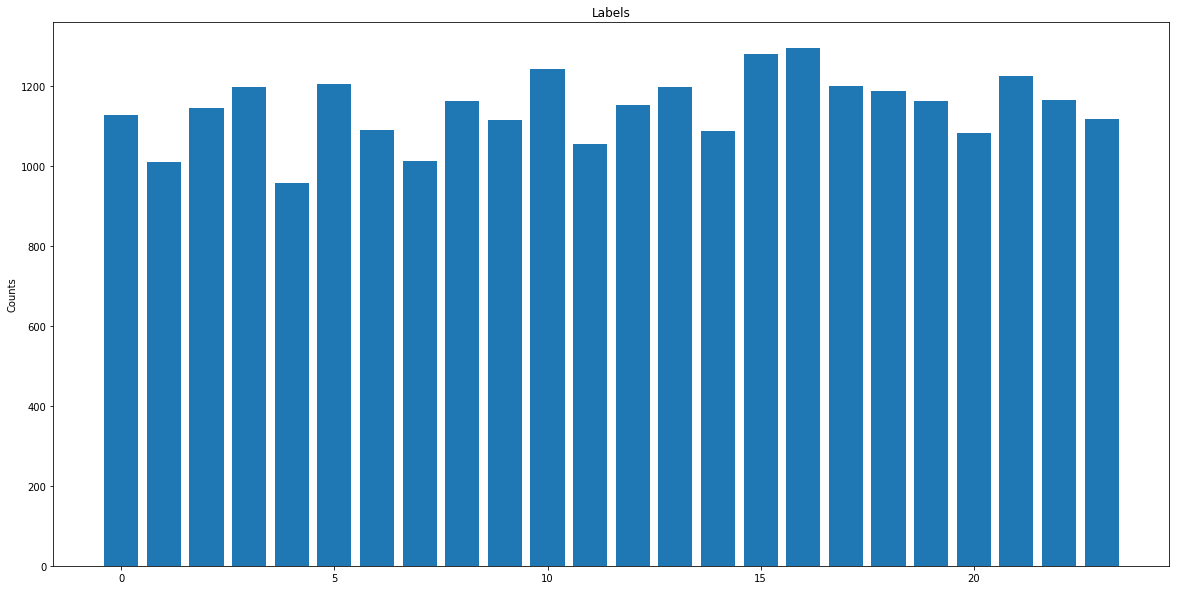

In [86]:
plt.subplots(figsize = (20,10))
plt.bar([k for k in counts.keys()], [k for k in counts.values()], align='center')
plt.ylabel('Counts')
plt.title('Labels')

plt.show()

# Part 1 : Prepare the whole dataset for training/testing the model (add class "point down")

In [87]:
X_Train = [img_to_sample(img) for img in train_set.values]
#X_Train.extend([np.rot90(row_to_image(row), 2) for row in train_set.iterrows() if row[1]["label"] == 3])

Y_Train = [[1 if i==int(label) else 0 for i in range(NUMBER_OF_CLASSES)] for label in train_set.label.values]
#Y_Train.extend([[1 if i==NUMBER_OF_CLASSES-1 else 0 for i in range(NUMBER_OF_CLASSES)] for row in train_set.iterrows() if row[1]["label"] == 3])

X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

In [88]:
X_Test = [img_to_sample(img) for img in test_set.values]
#X_Test.extend([np.rot90(row_to_image(row), 2) for row in test_set.iterrows() if row[1]["label"] == 3])

Y_Test = [[1 if i==int(label) else 0 for i in range(NUMBER_OF_CLASSES)] for label in test_set.label.values]
#Y_Test.extend([[1 if i==NUMBER_OF_CLASSES else 0 for i in range(NUMBER_OF_CLASSES)] for row in test_set.iterrows() if row[1]["label"] == 3])

X_Test = np.array(X_Test)
Y_Test = np.array(Y_Test)

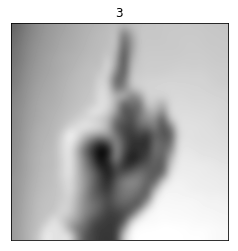

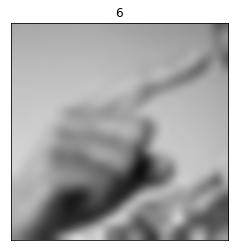

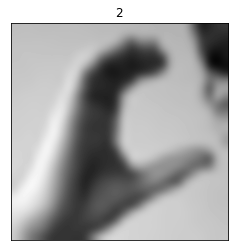

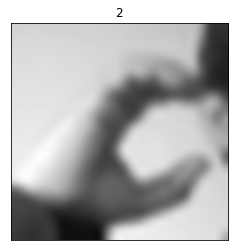

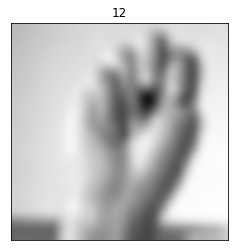

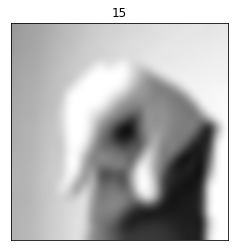

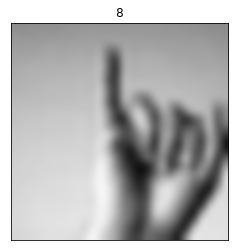

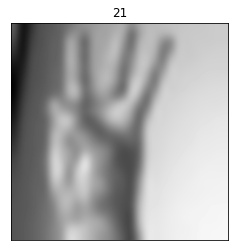

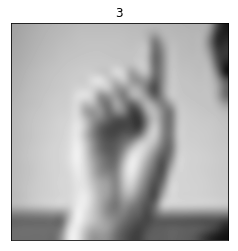

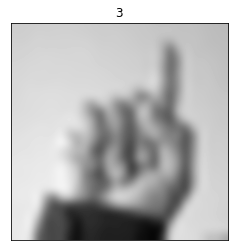

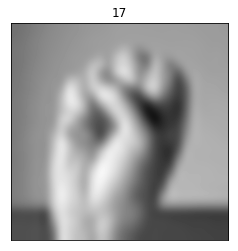

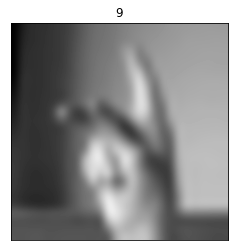

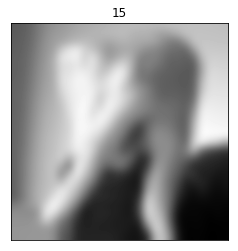

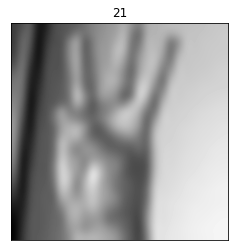

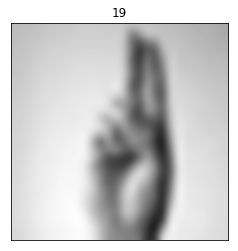

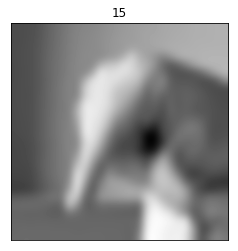

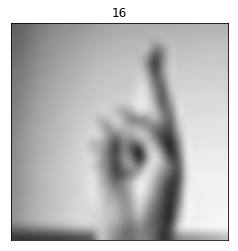

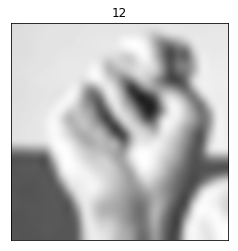

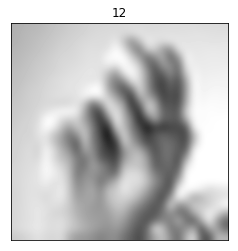

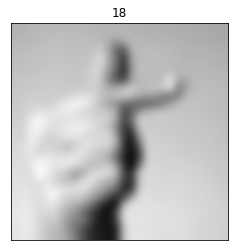

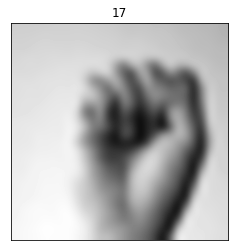

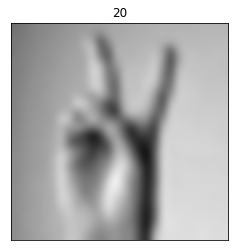

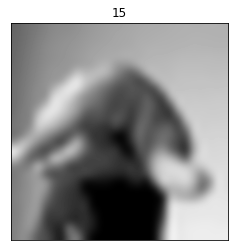

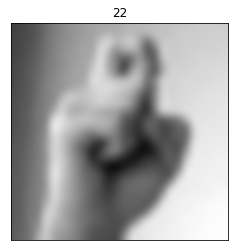

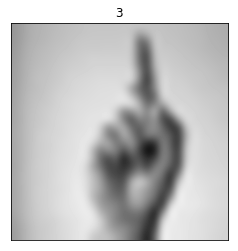

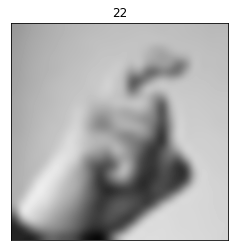

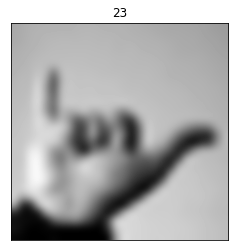

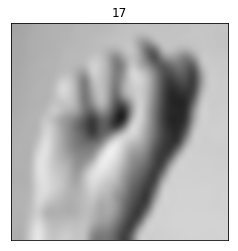

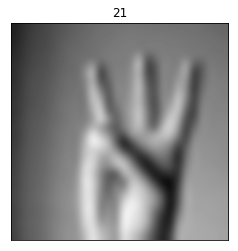

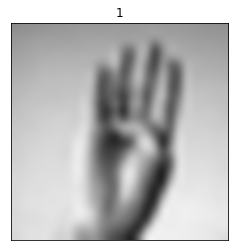

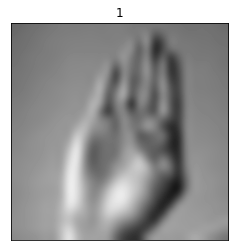

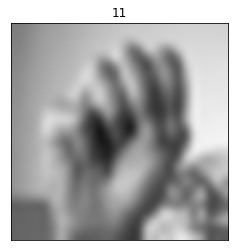

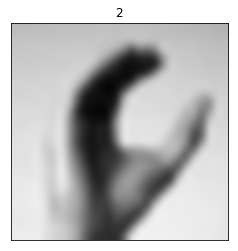

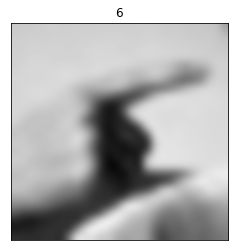

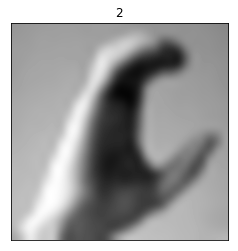

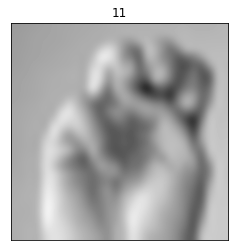

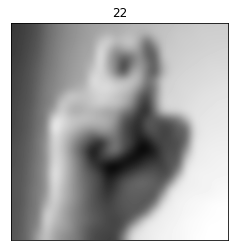

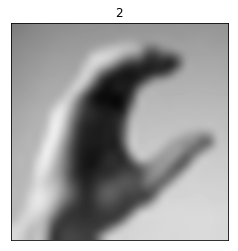

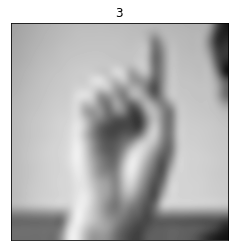

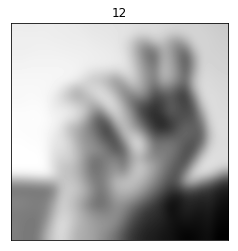

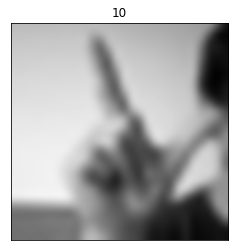

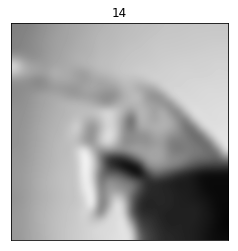

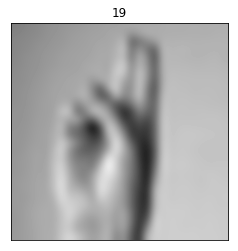

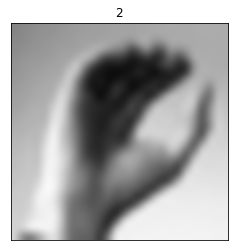

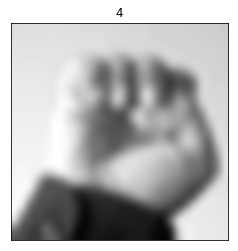

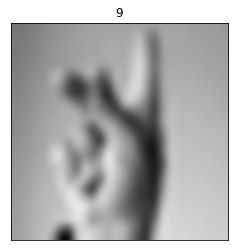

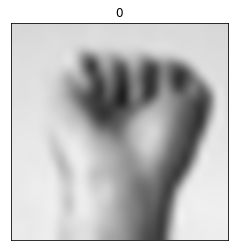

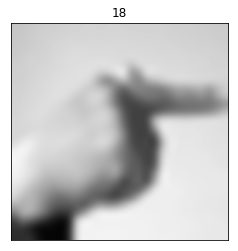

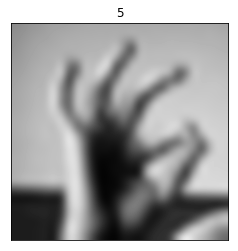

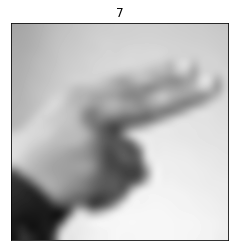

In [89]:
for i in range(50):
    plt.imshow(X_Train[i,:].reshape((28, 28))*255, cmap='gray', interpolation='bicubic')
    plt.title(np.argmax(Y_Train[i]))
    plt.xticks([]), plt.yticks([])
    plt.show()

In [90]:
X_Train.shape

(27455, 28, 28, 1)

In [91]:
Y_Train.shape

(27455, 24)

# Part 1 bis : Experimentation, creating a open/closed hand dataset with data augmentation

In [96]:
open_hands = list(chain.from_iterable( (img_to_sample(img), np.rot90(img_to_sample(img), 1), np.rot90(img_to_sample(img), 2), np.rot90(img_to_sample(img), 3), np.fliplr(img_to_sample(img)), np.fliplr(np.rot90(img_to_sample(img), 1)), np.fliplr(np.rot90(img_to_sample(img), 2)), np.fliplr(np.rot90(img_to_sample(img), 3))) for img in train_set.values if img[0] == 1)) + list(chain.from_iterable( (img_to_sample(img), np.rot90(img_to_sample(img), 1), np.rot90(img_to_sample(img), 2), np.rot90(img_to_sample(img), 3), np.fliplr(img_to_sample(img)), np.fliplr(np.rot90(img_to_sample(img), 1)), np.fliplr(np.rot90(img_to_sample(img), 2)), np.fliplr(np.rot90(img_to_sample(img), 3))) for img in test_set.values if img[0] == 1))


closed_hands = list(chain.from_iterable( (img_to_sample(img), np.rot90(img_to_sample(img), 1), np.rot90(img_to_sample(img), 2), np.rot90(img_to_sample(img), 3), np.fliplr(img_to_sample(img)), np.fliplr(np.rot90(img_to_sample(img), 1)), np.fliplr(np.rot90(img_to_sample(img), 2)), np.fliplr(np.rot90(img_to_sample(img), 3))) for i, img in enumerate(train_set.values) if img[0] in [0, 4, 11, 12, 17] and i <= 7000))

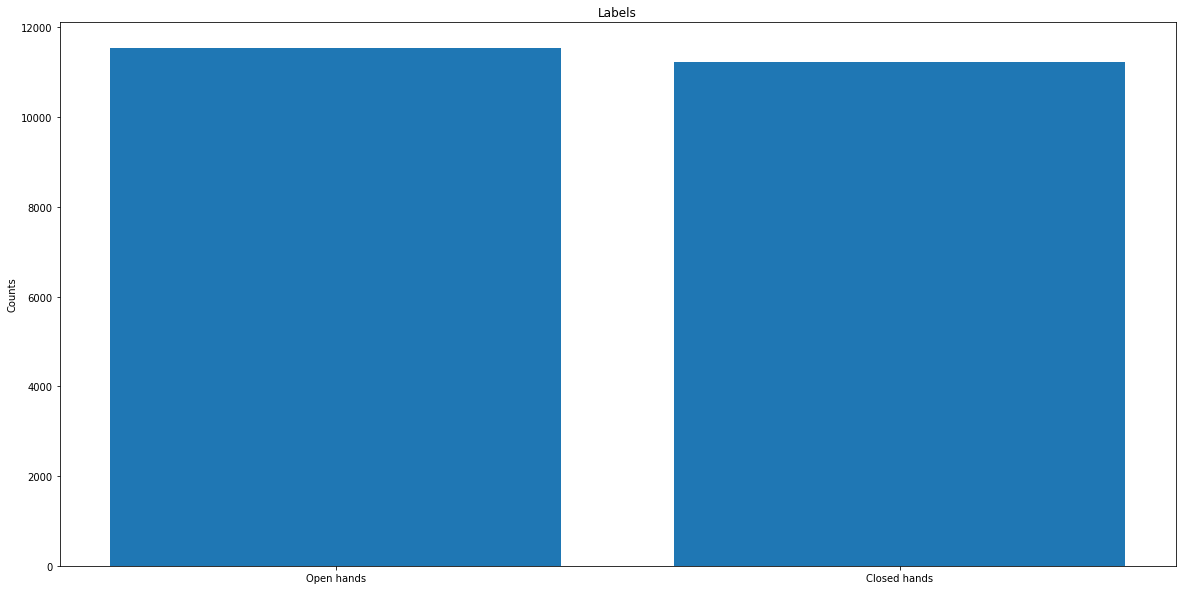

In [97]:
plt.subplots(figsize = (20,10))
plt.bar(["Open hands", "Closed hands"], [len(open_hands), len(closed_hands)], align='center')
plt.ylabel('Counts')
plt.title('Labels')

plt.show()

In [110]:
X_Train = closed_hands + open_hands

Y_Train = [[1, 0] if i < len(closed_hands) else [0, 1] for i in range(len(closed_hands) + len(open_hands))]


X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

In [111]:
X_Train.shape

(22768, 28, 28, 1)

In [112]:
Y_Train.shape

(22768, 2)

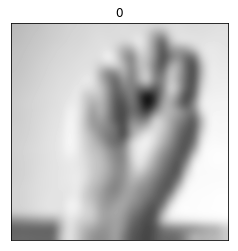

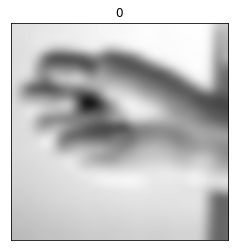

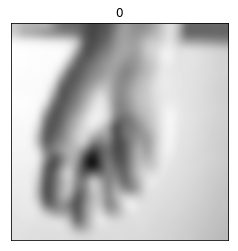

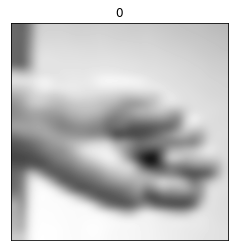

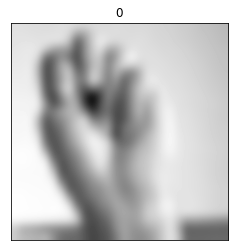

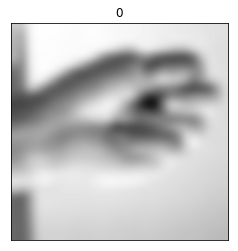

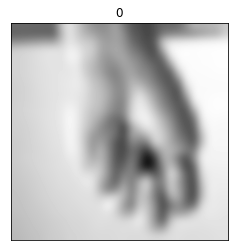

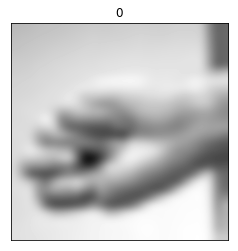

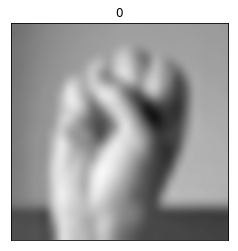

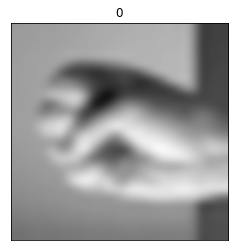

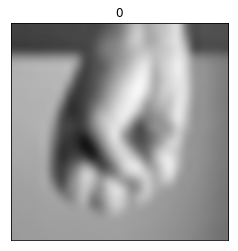

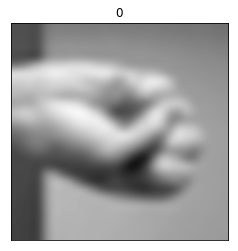

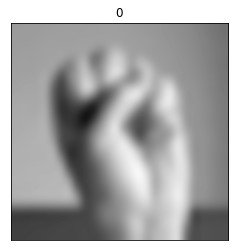

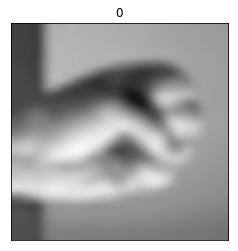

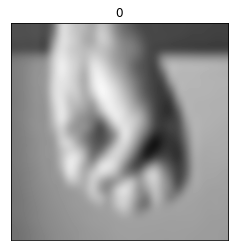

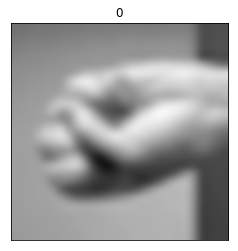

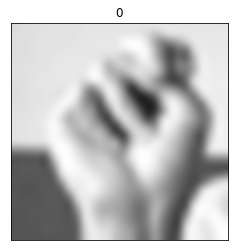

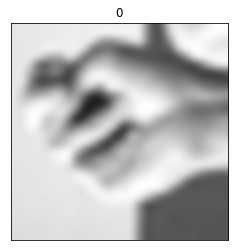

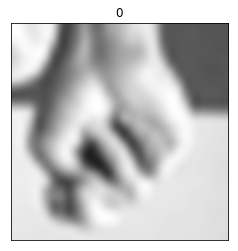

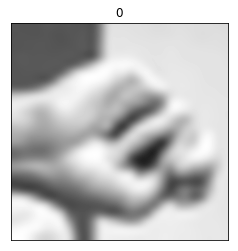

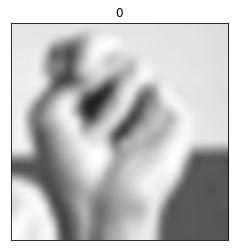

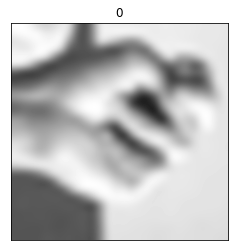

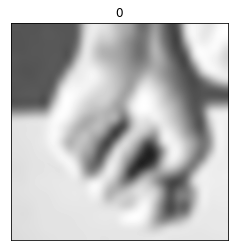

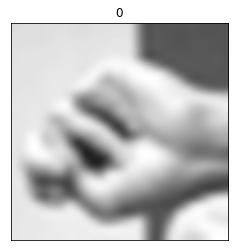

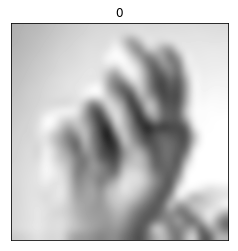

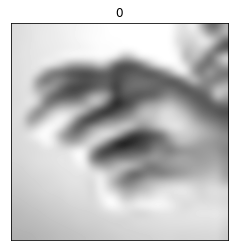

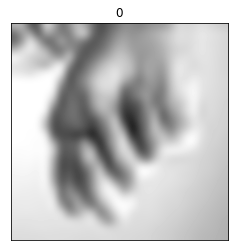

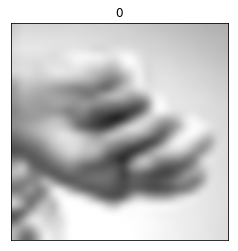

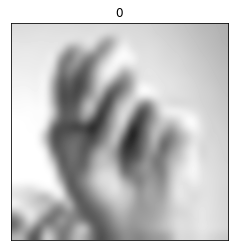

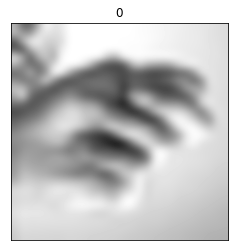

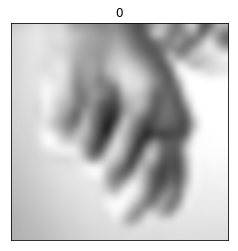

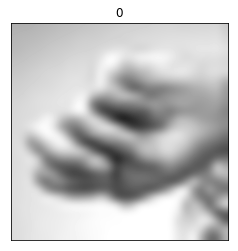

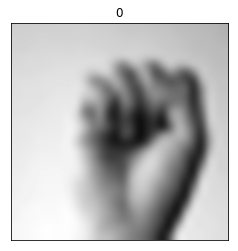

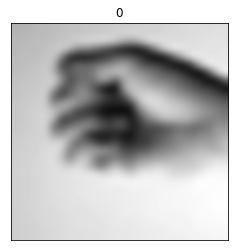

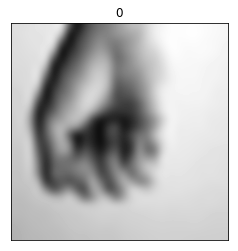

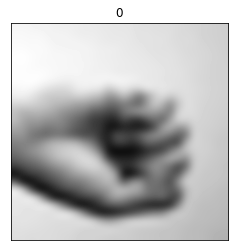

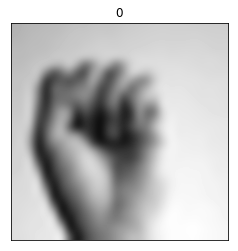

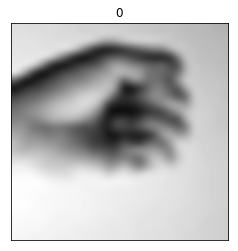

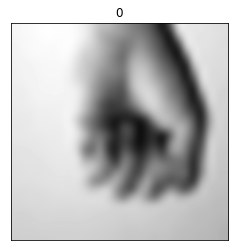

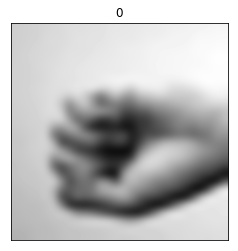

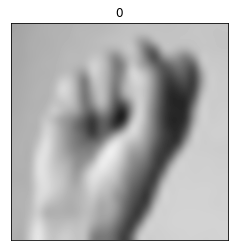

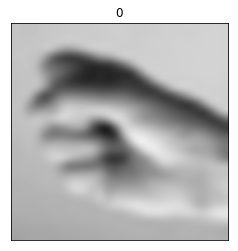

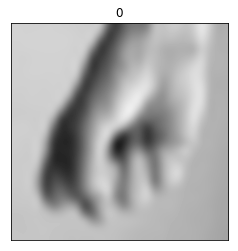

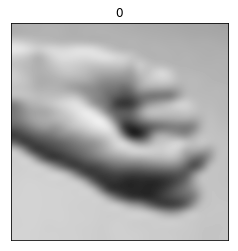

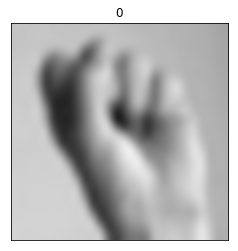

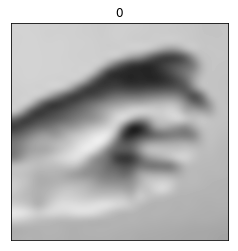

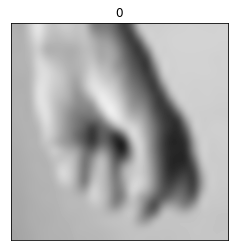

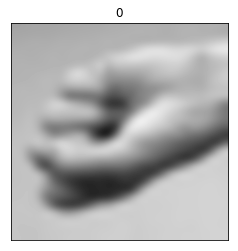

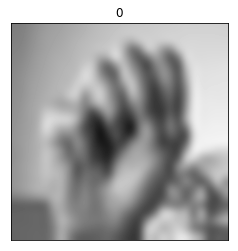

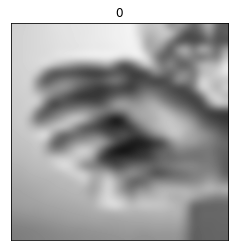

In [113]:
for i in range(50):
    plt.imshow(X_Train[i,:].reshape((28, 28))*255, cmap='gray', interpolation='bicubic')
    plt.title(np.argmax(Y_Train[i]))
    plt.xticks([]), plt.yticks([])
    plt.show()

# Part 2 : Training 

In [114]:
def HandModel(input_shape):
    
    X_input = Input(input_shape, name = "input_layer")

    # Zero-Padding
    X = ZeroPadding2D((2, 2), name = "zeropadding_1")(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(6, (5, 5), strides = (1, 1), name = 'conv1')(X)
    X = Activation('relu', name = "relu_1")(X)

    # AVERAGEPOOL
    X = AveragePooling2D(pool_size = (2, 2), name='average_pool1')(X)
    
    # Zero-Padding
    X = ZeroPadding2D((2, 2), name = "zeropadding_2")(X)
    
    # CONV -> RELU Block applied to X
    X = Conv2D(16, (5, 5), strides = (1, 1), name = 'conv2')(X)
    X = Activation('relu', name = "relu_2")(X)

    # AVERAGEPOOL
    X = AveragePooling2D(pool_size = (2, 2), strides = (2, 2), name='average_pool2')(X)

    # FLATTEN X + FULLYCONNECTED
    X = Flatten(name='flatten_1')(X)
    X = Dense(16, activation='relu', name='dense_1')(X)
    
    #DROPOUT
    #X = Dropout(0.1, name = "dropout_1")(X)
    
    # FULLYCONNECTED
    X = Dense(4, activation='relu', name='dense_2')(X)
    
    # FULLYCONNECTED (SOFTMAX) if MANY CLASSES PREDICTION
    X = Dense(OUTPUT_LAYER_NEURONS, activation='softmax', name='output_layer')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HandModel')

    return model

In [115]:
X_Train.shape[1:]

(28, 28, 1)

In [116]:
model = HandModel(X_Train.shape[1:])

In [117]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 28, 28, 1)         0         
_________________________________________________________________
zeropadding_1 (ZeroPadding2D (None, 32, 32, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 6)         156       
_________________________________________________________________
relu_1 (Activation)          (None, 28, 28, 6)         0         
_________________________________________________________________
average_pool1 (AveragePoolin (None, 14, 14, 6)         0         
_________________________________________________________________
zeropadding_2 (ZeroPadding2D (None, 18, 18, 6)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 16)        2416      
__________

In [118]:
model.compile("Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [119]:
with open('handmodel_architecture.json', 'w') as f:
    f.write(model.to_json())

In [120]:
filename = "handmodel_weights.hdf5"
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', verbose=1, min_delta=0, patience=10, mode='min')
callbacks_list = [checkpoint, earlyStopping]

In [121]:
history = model.fit(x = X_Train, y = Y_Train, validation_split=0.20, batch_size=256, epochs = EPOCHS, callbacks=callbacks_list)

Train on 18214 samples, validate on 4554 samples
Epoch 1/100
18214/18214 [==============================] - 15s 800us/step - loss: 0.6645 - acc: 0.6155 - val_loss: 1.0672 - val_acc: 0.0000e+00

Epoch 00001: loss improved from inf to 0.66451, saving model to handmodel_weights.hdf5
Epoch 2/100
18214/18214 [==============================] - 15s 813us/step - loss: 0.5675 - acc: 0.6860 - val_loss: 0.5600 - val_acc: 0.7448

Epoch 00002: loss improved from 0.66451 to 0.56747, saving model to handmodel_weights.hdf5
Epoch 3/100
18214/18214 [==============================] - 16s 868us/step - loss: 0.3524 - acc: 0.8671 - val_loss: 0.4020 - val_acc: 0.84967s  - ETA: 1s - loss: 0.3647 - 

Epoch 00003: loss improved from 0.56747 to 0.35240, saving model to handmodel_weights.hdf5
Epoch 4/100
18214/18214 [==============================] - 16s 862us/step - loss: 0.2126 - acc: 0.9252 - val_loss: 0.4545 - val_acc: 0.7809

Epoch 00004: loss improved from 0.35240 to 0.21260, saving model to handmodel_weigh

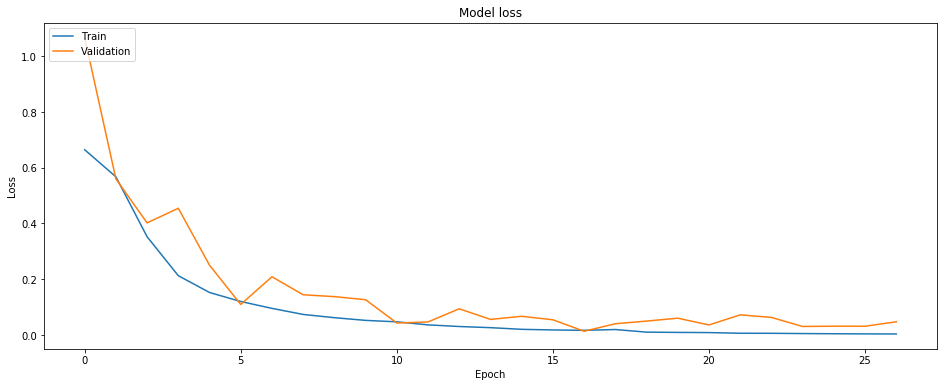

In [122]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Part 3 : Testing

In [123]:
model = loadModel()

In [124]:
preds = model.predict(X_Test)

In [54]:
preds = (preds > 0.5).astype(int)
for predicted, real in zip(preds, Y_Test):
    ip = np.where(predicted == 1)
    ir = np.where(real == 1)
    print("Predicted : {}, Real : {} ".format(ip[0], ir[0]))

Predicted : [6], Real : [6] 
Predicted : [5], Real : [5] 
Predicted : [9], Real : [9] 
Predicted : [0], Real : [0] 
Predicted : [3], Real : [3] 
Predicted : [20], Real : [20] 
Predicted : [9], Real : [9] 
Predicted : [13], Real : [13] 
Predicted : [3], Real : [3] 
Predicted : [7], Real : [7] 
Predicted : [8], Real : [8] 
Predicted : [8], Real : [8] 
Predicted : [20], Real : [20] 
Predicted : [11], Real : [11] 
Predicted : [7], Real : [7] 
Predicted : [4], Real : [4] 
Predicted : [21], Real : [21] 
Predicted : [0], Real : [0] 
Predicted : [7], Real : [7] 
Predicted : [7], Real : [7] 
Predicted : [2], Real : [2] 
Predicted : [0], Real : [0] 
Predicted : [20], Real : [20] 
Predicted : [4], Real : [4] 
Predicted : [9], Real : [9] 
Predicted : [14], Real : [14] 
Predicted : [2], Real : [2] 
Predicted : [14], Real : [14] 
Predicted : [7], Real : [7] 
Predicted : [1], Real : [1] 
Predicted : [7], Real : [7] 
Predicted : [8], Real : [8] 
Predicted : [12], Real : [12] 
Predicted : [18], Real : 

Predicted : [6], Real : [6] 
Predicted : [12], Real : [12] 
Predicted : [1], Real : [1] 
Predicted : [14], Real : [14] 
Predicted : [0], Real : [0] 
Predicted : [8], Real : [8] 
Predicted : [0], Real : [0] 
Predicted : [5], Real : [13] 
Predicted : [11], Real : [11] 
Predicted : [7], Real : [7] 
Predicted : [20], Real : [20] 
Predicted : [8], Real : [8] 
Predicted : [12], Real : [11] 
Predicted : [9], Real : [9] 
Predicted : [2], Real : [2] 
Predicted : [1], Real : [1] 
Predicted : [18], Real : [18] 
Predicted : [2], Real : [2] 
Predicted : [9], Real : [23] 
Predicted : [20], Real : [20] 
Predicted : [8], Real : [8] 
Predicted : [10], Real : [23] 
Predicted : [3], Real : [3] 
Predicted : [17], Real : [17] 
Predicted : [0], Real : [0] 
Predicted : [6], Real : [6] 
Predicted : [1], Real : [1] 
Predicted : [10], Real : [10] 
Predicted : [20], Real : [20] 
Predicted : [13], Real : [13] 
Predicted : [15], Real : [6] 
Predicted : [0], Real : [0] 
Predicted : [10], Real : [10] 
Predicted : [1

Predicted : [6], Real : [7] 
Predicted : [7], Real : [7] 
Predicted : [10], Real : [10] 
Predicted : [18], Real : [12] 
Predicted : [17], Real : [17] 
Predicted : [2], Real : [2] 
Predicted : [10], Real : [10] 
Predicted : [14], Real : [14] 
Predicted : [19], Real : [19] 
Predicted : [5], Real : [13] 
Predicted : [10], Real : [10] 
Predicted : [11], Real : [17] 
Predicted : [19], Real : [19] 
Predicted : [8], Real : [8] 
Predicted : [7], Real : [7] 
Predicted : [12], Real : [11] 
Predicted : [21], Real : [21] 
Predicted : [20], Real : [20] 
Predicted : [14], Real : [14] 
Predicted : [1], Real : [1] 
Predicted : [5], Real : [9] 
Predicted : [13], Real : [13] 
Predicted : [0], Real : [0] 
Predicted : [5], Real : [9] 
Predicted : [7], Real : [7] 
Predicted : [4], Real : [4] 
Predicted : [23], Real : [23] 
Predicted : [23], Real : [8] 
Predicted : [21], Real : [21] 
Predicted : [11], Real : [11] 
Predicted : [16], Real : [9] 
Predicted : [22], Real : [22] 
Predicted : [22], Real : [3] 
Pre

Predicted : [9], Real : [9] 
Predicted : [13], Real : [13] 
Predicted : [12], Real : [12] 
Predicted : [6], Real : [6] 
Predicted : [11], Real : [11] 
Predicted : [14], Real : [20] 
Predicted : [14], Real : [14] 
Predicted : [2], Real : [2] 
Predicted : [19], Real : [19] 
Predicted : [4], Real : [4] 
Predicted : [7], Real : [7] 
Predicted : [12], Real : [11] 
Predicted : [1], Real : [1] 
Predicted : [14], Real : [14] 
Predicted : [0], Real : [0] 
Predicted : [5], Real : [13] 
Predicted : [2], Real : [12] 
Predicted : [9], Real : [9] 
Predicted : [4], Real : [4] 
Predicted : [6], Real : [7] 
Predicted : [17], Real : [4] 
Predicted : [3], Real : [3] 
Predicted : [20], Real : [20] 
Predicted : [1], Real : [1] 
Predicted : [19], Real : [20] 
Predicted : [20], Real : [20] 
Predicted : [5], Real : [5] 
Predicted : [4], Real : [4] 
Predicted : [10], Real : [10] 
Predicted : [4], Real : [4] 
Predicted : [3], Real : [19] 
Predicted : [1], Real : [1] 
Predicted : [14], Real : [14] 
Predicted : [

Predicted : [8], Real : [8] 
Predicted : [20], Real : [20] 
Predicted : [0], Real : [0] 
Predicted : [17], Real : [4] 
Predicted : [19], Real : [19] 
Predicted : [10], Real : [10] 
Predicted : [18], Real : [6] 
Predicted : [2], Real : [2] 
Predicted : [22], Real : [22] 
Predicted : [10], Real : [10] 
Predicted : [7], Real : [7] 
Predicted : [2], Real : [2] 
Predicted : [8], Real : [8] 
Predicted : [1], Real : [1] 
Predicted : [7], Real : [7] 
Predicted : [16], Real : [16] 
Predicted : [10], Real : [23] 
Predicted : [20], Real : [20] 
Predicted : [4], Real : [4] 
Predicted : [1], Real : [1] 
Predicted : [14], Real : [14] 
Predicted : [8], Real : [8] 
Predicted : [20], Real : [20] 
Predicted : [16], Real : [16] 
Predicted : [11], Real : [15] 
Predicted : [5], Real : [5] 
Predicted : [4], Real : [4] 
Predicted : [21], Real : [21] 
Predicted : [4], Real : [4] 
Predicted : [12], Real : [12] 
Predicted : [11], Real : [11] 
Predicted : [17], Real : [17] 
Predicted : [0], Real : [0] 
Predicted

Predicted : [22], Real : [22] 
Predicted : [3], Real : [3] 
Predicted : [3], Real : [3] 
Predicted : [15], Real : [15] 
Predicted : [12], Real : [12] 
Predicted : [0], Real : [0] 
Predicted : [0], Real : [0] 
Predicted : [11], Real : [11] 
Predicted : [8], Real : [8] 
Predicted : [18], Real : [18] 
Predicted : [16], Real : [19] 
Predicted : [15], Real : [15] 
Predicted : [1], Real : [1] 
Predicted : [9], Real : [9] 
Predicted : [20], Real : [20] 
Predicted : [5], Real : [5] 
Predicted : [14], Real : [20] 
Predicted : [23], Real : [23] 
Predicted : [10], Real : [10] 
Predicted : [8], Real : [8] 
Predicted : [14], Real : [14] 
Predicted : [7], Real : [7] 
Predicted : [2], Real : [2] 
Predicted : [7], Real : [7] 
Predicted : [8], Real : [8] 
Predicted : [11], Real : [11] 
Predicted : [14], Real : [14] 
Predicted : [13], Real : [13] 
Predicted : [11], Real : [11] 
Predicted : [7], Real : [7] 
Predicted : [4], Real : [4] 
Predicted : [4], Real : [4] 
Predicted : [15], Real : [15] 
Predicted

Predicted : [20], Real : [20] 
Predicted : [0], Real : [12] 
Predicted : [1], Real : [1] 
Predicted : [13], Real : [13] 
Predicted : [6], Real : [6] 
Predicted : [17], Real : [17] 
Predicted : [12], Real : [12] 
Predicted : [20], Real : [20] 
Predicted : [12], Real : [12] 
Predicted : [], Real : [10] 
Predicted : [8], Real : [8] 
Predicted : [3], Real : [3] 
Predicted : [10], Real : [10] 
Predicted : [11], Real : [11] 
Predicted : [5], Real : [5] 
Predicted : [4], Real : [4] 
Predicted : [23], Real : [23] 
Predicted : [19], Real : [19] 
Predicted : [9], Real : [9] 
Predicted : [4], Real : [4] 
Predicted : [22], Real : [22] 
Predicted : [20], Real : [16] 
Predicted : [5], Real : [5] 
Predicted : [15], Real : [15] 
Predicted : [20], Real : [20] 
Predicted : [1], Real : [1] 
Predicted : [23], Real : [23] 
Predicted : [7], Real : [7] 
Predicted : [5], Real : [20] 
Predicted : [6], Real : [7] 
Predicted : [22], Real : [22] 
Predicted : [11], Real : [11] 
Predicted : [4], Real : [4] 
Predict

Predicted : [5], Real : [5] 
Predicted : [14], Real : [14] 
Predicted : [4], Real : [4] 
Predicted : [15], Real : [12] 
Predicted : [15], Real : [15] 
Predicted : [5], Real : [5] 
Predicted : [11], Real : [11] 
Predicted : [7], Real : [7] 
Predicted : [18], Real : [12] 
Predicted : [20], Real : [20] 
Predicted : [10], Real : [10] 
Predicted : [19], Real : [19] 
Predicted : [5], Real : [5] 
Predicted : [18], Real : [18] 
Predicted : [0], Real : [0] 
Predicted : [6], Real : [6] 
Predicted : [0], Real : [0] 
Predicted : [3], Real : [19] 
Predicted : [18], Real : [18] 
Predicted : [23], Real : [23] 
Predicted : [14], Real : [14] 
Predicted : [4], Real : [4] 
Predicted : [11], Real : [11] 
Predicted : [18], Real : [18] 
Predicted : [10], Real : [10] 
Predicted : [11], Real : [17] 
Predicted : [1], Real : [1] 
Predicted : [12], Real : [12] 
Predicted : [11], Real : [11] 
Predicted : [12], Real : [12] 
Predicted : [23], Real : [23] 
Predicted : [0], Real : [0] 
Predicted : [12], Real : [12] 


Predicted : [0], Real : [0] 
Predicted : [4], Real : [4] 
Predicted : [12], Real : [12] 
Predicted : [15], Real : [15] 
Predicted : [6], Real : [6] 
Predicted : [19], Real : [19] 
Predicted : [5], Real : [5] 
Predicted : [7], Real : [7] 
Predicted : [3], Real : [3] 
Predicted : [17], Real : [17] 
Predicted : [17], Real : [17] 
Predicted : [17], Real : [11] 
Predicted : [23], Real : [23] 
Predicted : [20], Real : [20] 
Predicted : [4], Real : [4] 
Predicted : [23], Real : [23] 
Predicted : [0], Real : [0] 
Predicted : [12], Real : [12] 
Predicted : [11], Real : [11] 
Predicted : [11], Real : [17] 
Predicted : [13], Real : [13] 
Predicted : [8], Real : [8] 
Predicted : [21], Real : [22] 
Predicted : [4], Real : [4] 
Predicted : [9], Real : [9] 
Predicted : [15], Real : [12] 
Predicted : [19], Real : [20] 
Predicted : [15], Real : [15] 
Predicted : [7], Real : [7] 
Predicted : [10], Real : [23] 
Predicted : [17], Real : [13] 
Predicted : [23], Real : [23] 
Predicted : [14], Real : [14] 
P

In [55]:
y_preds = [l.index(1) if 1 in l else 0 for l in preds.tolist()]

In [56]:
y_true = [l.index(1) for l in Y_Test.tolist()]

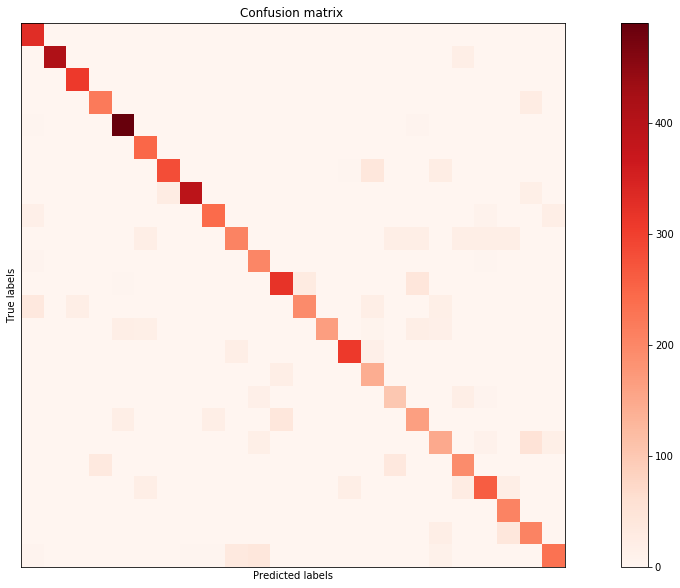

In [57]:
cm = confusion_matrix(y_true, y_preds)

plt.subplots(figsize=(20, 10))
plt.imshow(cm, cmap=plt.cm.Reds)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

# Test with own image

In [69]:
test = cv2.imread("closed.png", 0)

In [70]:
test

array([[206, 205, 205, ..., 173, 174, 174],
       [206, 206, 206, ..., 174, 174, 174],
       [206, 207, 206, ..., 174, 174, 174],
       ...,
       [156, 156, 155, ..., 141, 143, 144],
       [158, 156, 155, ..., 143, 144, 145],
       [159, 156, 155, ..., 144, 144, 144]], dtype=uint8)

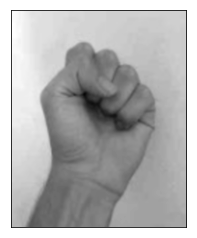

In [71]:
plt.imshow(test, cmap='gray', interpolation='bicubic')
plt.xticks([]), plt.yticks([])
plt.show()

In [72]:
test = cv2.resize(test, (28, 28))

In [73]:
test

array([[206, 201, 195, 187, 188, 186, 186, 183, 183, 179, 180, 180, 178,
        178, 178, 174, 174, 174, 174, 174, 174, 175, 174, 174, 174, 174,
        174, 174],
       [206, 202, 197, 192, 186, 186, 186, 183, 180, 177, 177, 180, 177,
        177, 177, 174, 174, 174, 172, 171, 173, 172, 171, 171, 173, 174,
        174, 176],
       [209, 206, 197, 189, 186, 186, 186, 182, 180, 180, 178, 177, 177,
        176, 174, 174, 174, 172, 172, 172, 168, 168, 171, 171, 172, 172,
        174, 172],
       [210, 204, 197, 191, 186, 186, 185, 182, 178, 180, 178, 174, 178,
        175, 175, 175, 171, 171, 170, 169, 168, 168, 168, 168, 171, 171,
        171, 170],
       [205, 202, 197, 190, 186, 183, 179, 175, 174, 180, 153, 118, 144,
        174, 173, 172, 171, 170, 168, 166, 166, 168, 166, 164, 169, 171,
        171, 170],
       [206, 205, 197, 190, 186, 179, 175, 177, 178, 111, 113, 117, 119,
        159, 128, 115, 154, 168, 168, 165, 165, 165, 164, 166, 167, 171,
        171, 170],
       [20

In [74]:
test = test.reshape((1, 28, 28, 1))

In [75]:
test = test/255

In [76]:
test

array([[[[0.80784314],
         [0.78823529],
         [0.76470588],
         [0.73333333],
         [0.7372549 ],
         [0.72941176],
         [0.72941176],
         [0.71764706],
         [0.71764706],
         [0.70196078],
         [0.70588235],
         [0.70588235],
         [0.69803922],
         [0.69803922],
         [0.69803922],
         [0.68235294],
         [0.68235294],
         [0.68235294],
         [0.68235294],
         [0.68235294],
         [0.68235294],
         [0.68627451],
         [0.68235294],
         [0.68235294],
         [0.68235294],
         [0.68235294],
         [0.68235294],
         [0.68235294]],

        [[0.80784314],
         [0.79215686],
         [0.77254902],
         [0.75294118],
         [0.72941176],
         [0.72941176],
         [0.72941176],
         [0.71764706],
         [0.70588235],
         [0.69411765],
         [0.69411765],
         [0.70588235],
         [0.69411765],
         [0.69411765],
         [0.69411765],
         

In [88]:
preds = model.predict(test)

In [90]:
np.argmax(preds)

14

# Test model in real time

In [134]:
model = loadModel()

In [135]:
cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.flip(gray,1)
       
    # Draw the zone that will capture the hand 
    cv2.rectangle(gray,(10,100),(260,350),(0,255,0),3)
    
    # Capture the hand zone
    zone = gray[100:350, 10:260]
    
    zone = process_image(zone)
    
    zone = zone.reshape((1, 28, 28, 1))
    preds = model.predict(zone)
    
    #categorical
    predicted_class = np.argmax(preds)
    
    if predicted_class == 1:
        keyboard.press(Key.space)
    else:
        keyboard.release(Key.space)
    
    
    cv2.putText(gray,indice_to_gesture[int(predicted_class)],(0,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)

    # Display the resulting frame
    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break                                                                                                                     

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

# Try model on FlappyBird